# Modelling and Tracking Shared E-Scooters

Analyze the effects of correlated noise on the Kalman filter's performance.

- Investigate the effects of ignoring correlated state and measurement noise by using a Kalman filter that assumes uncorrelated noise.
- Develop an optimal Kalman filter that properly models correlated state noise and compares its performance.

In [51]:
import numpy as np
import matplotlib.pyplot as plt

N = 200  
T = 1.0  
x0 = 5.0 
v0 = 1.0 

sigma_a_val = 0.2    
sigma_eta_val = 20.0 
sigma_a_sq = sigma_a_val**2
sigma_eta_sq = sigma_eta_val**2

Motion model is perturbed by CORRELATED random acceleration

In [52]:
def generate_correlated_noise(lambda_val, sigma_correlated_sq, T, N):
    sigma_driving_sq = sigma_correlated_sq * (1 - np.exp(-2 * lambda_val * T))
    driving_noise = np.random.normal(0, np.sqrt(sigma_driving_sq), N)
    
    correlated_noise = np.zeros(N)
    for i in range(1, N):
        correlated_noise[i] = np.exp(-lambda_val * T) * correlated_noise[i-1] + driving_noise[i]
    return correlated_noise

def generate_trajectory_and_measurements(lambda_a, lambda_eta, N, T, x0, v0):
    a = generate_correlated_noise(lambda_a, sigma_a_sq, T, N)
    eta = generate_correlated_noise(lambda_eta, sigma_eta_sq, T, N)
    
    x_true = np.zeros(N)
    v_true = np.zeros(N)
    x_true[0], v_true[0] = x0, v0
    
    for i in range(1, N):
        v_true[i] = v_true[i-1] + a[i-1] * T
        x_true[i] = x_true[i-1] + v_true[i-1] * T + a[i-1] * T**2 / 2
        
    z = x_true + eta
    return x_true, v_true, z

# Part I: Effects of Ignoring Correlated Noise

Use a Kalman filter that assumes both the state noise and measurement noise are uncorrelated (white). Test this filter under four different scenarios to observe the impact of violating its core assumptions.

In [53]:
Phi = np.array([[1, T], [0, 1]])
G = np.array([[T**2/2], [T]])
H = np.array([[1, 0]])
Ri = np.array([[sigma_eta_sq]])

X0_0_part1 = np.array([[2.0], [0.0]]) 
P0_0_part1 = np.array([[10000, 0], [0, 10000]])

def run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0, q_bias = None):
    Q = G @ G.T * sigma_a_sq

    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 2, 1))
    P_predicted = np.zeros((N, 2, 2))
    X_filtered = np.zeros((N, 2, 1))
    P_filtered = np.zeros((N, 2, 2))

    K_history = np.zeros((N, 2, 1))
    
    X_predicted_ahead = np.zeros(N)

    for i in range(N):
        # prediction stage
        X_pred = Phi @ X_filt_prev
        if q_bias is not None:
            X_pred += G @ q_bias

        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        # filtration stage
        residual = z[i] - H @ X_pred
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Ri)
        X_filt = X_pred + K @ residual
        I = np.eye(2)
        P_filt = (I - K @ H) @ P_pred

        # save data
        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        K_history[i] = K
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_filtered, P_filtered, X_predicted, P_predicted, K_history, X_predicted_ahead

def run_kalman_filter_and_calculate_errors(lambda_a, lambda_eta):
    M = 500 
    sq_errors = np.zeros((M, N))
    p_filtered_diags = np.zeros((M, N))

    for m in range(M):
        x_true, _, z = generate_trajectory_and_measurements(lambda_a, lambda_eta, N, T, x0, v0)
        X_filtered, P_filtered, _, _, _, _ = run_kalman_filter(z, N, sigma_a_sq, X0_0_part1, P0_0_part1)
        
        error = x_true - X_filtered[:, 0, 0]
        sq_errors[m, :] = error**2
        p_filtered_diags[m, :] = P_filtered[:, 0, 0]
        
    rmse = np.sqrt(np.mean(sq_errors, axis=0))
    avg_calc_std = np.sqrt(np.mean(p_filtered_diags, axis=0))
    
    return rmse, avg_calc_std

### Scenario 1: Optimal Filter (Uncorrelated State and Measurement Noise)

**Baseline case:** Both process and measurement noises are white and independent (`λ=1000`). The filter's assumptions match reality.

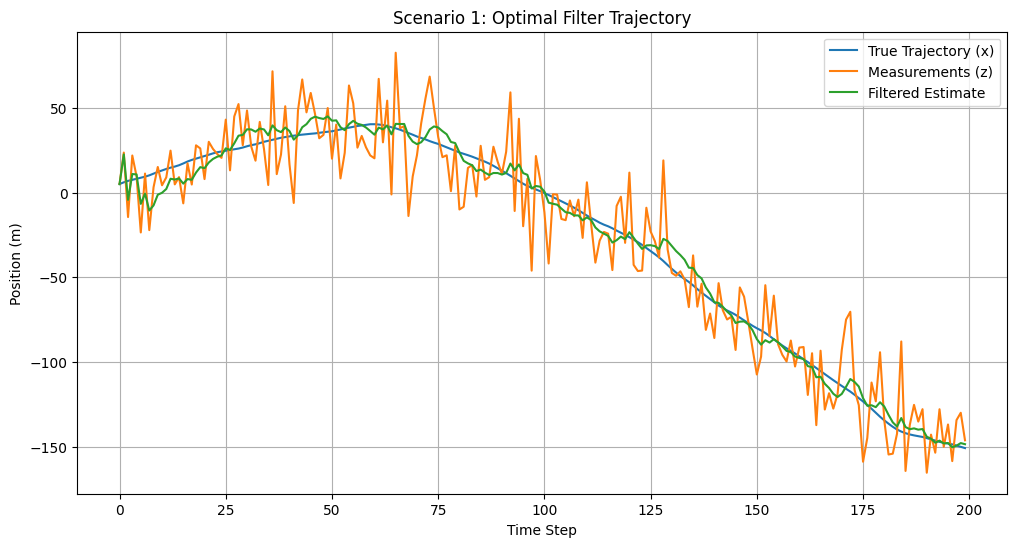

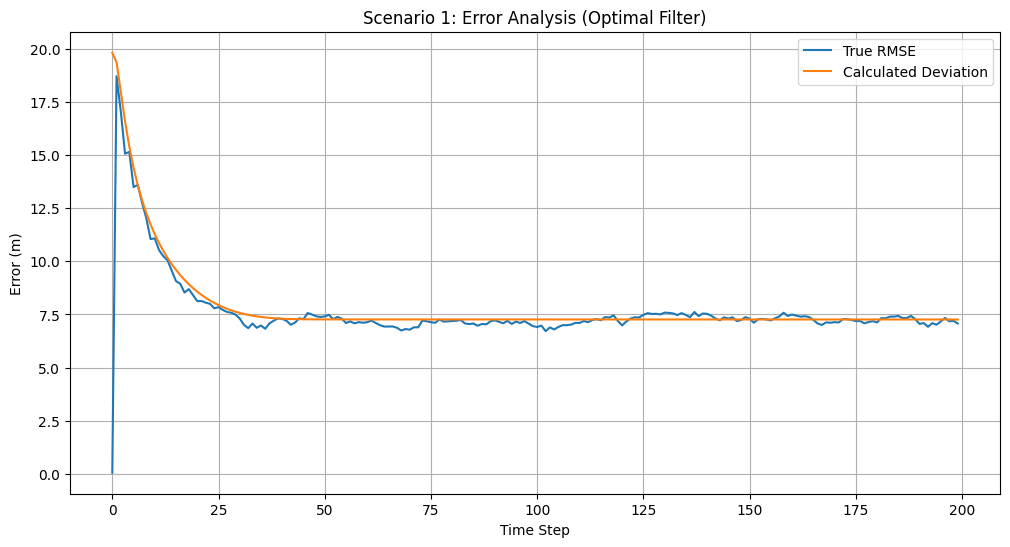

In [54]:
lambda_a_1, lambda_eta_1 = 1000, 1000
x_true_1, _, z_1 = generate_trajectory_and_measurements(lambda_a_1, lambda_eta_1, N, T, x0, v0)
X_filtered_1, _, _, _, _, _ = run_kalman_filter(z_1, N, sigma_a_sq, X0_0_part1, P0_0_part1)

plt.figure(figsize=(12, 6))
plt.plot(x_true_1, label='True Trajectory (x)')
plt.plot(z_1, markersize=3, label='Measurements (z)')
plt.plot(X_filtered_1[:, 0, 0], label='Filtered Estimate')
plt.title('Scenario 1: Optimal Filter Trajectory')
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

rmse_1, avg_calc_std_1 = run_kalman_filter_and_calculate_errors(lambda_a_1, lambda_eta_1)

plt.figure(figsize=(12, 6))
plt.plot(rmse_1, label='True RMSE')
plt.plot(avg_calc_std_1, label='Calculated Deviation')
plt.title('Scenario 1: Error Analysis (Optimal Filter)')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

In the optimal case, the calculated deviation from the filter's covariance matrix P closely matches the true Root Mean Square Error (RMSE). This indicates that the filter is consistent and provides a reliable estimate of its own uncertainty.

This filter is constructed under accurate assumptions about uncorrelated state and measurement noise, it provides an optimal estimates, allowing us to confidently rely on the calculated error.

### Scenario 2: Ignoring Correlated State Noise

**Non-optimal case:** The true acceleration is correlated (`λ=0.1`), but the filter assumes it is uncorrelated. Measurement noise is uncorrelated (`λ=1000`).

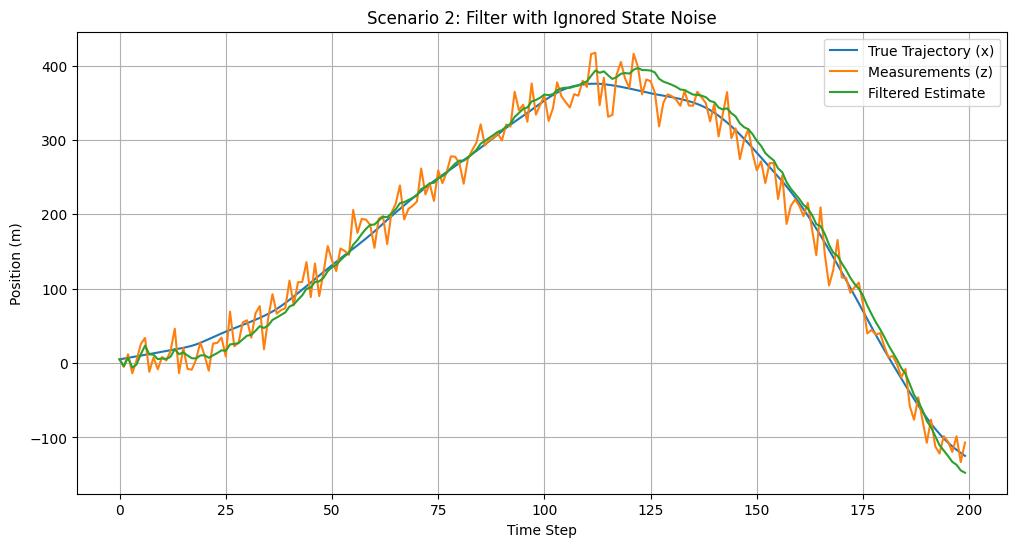

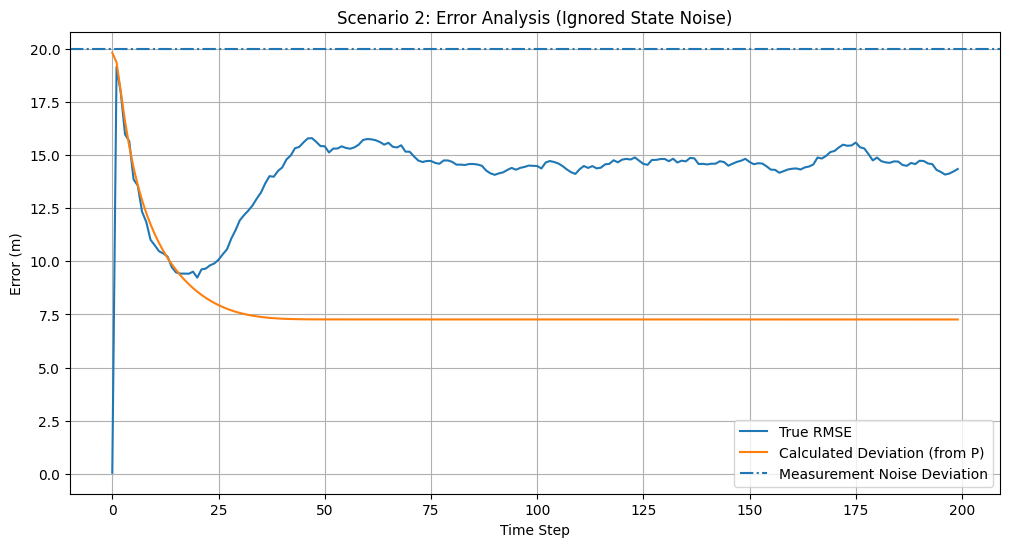

In [55]:
lambda_a_2, lambda_eta_2 = 0.1, 1000
x_true_2, _, z_2 = generate_trajectory_and_measurements(lambda_a_2, lambda_eta_2, N, T, x0, v0)
X_filtered_2, _, _, _, _, _ = run_kalman_filter(z_2, N, sigma_a_sq, X0_0_part1, P0_0_part1)

plt.figure(figsize=(12, 6))
plt.plot(x_true_2, label='True Trajectory (x)')
plt.plot(z_2, markersize=3, label='Measurements (z)')
plt.plot(X_filtered_2[:, 0, 0], label='Filtered Estimate')
plt.title('Scenario 2: Filter with Ignored State Noise')
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

rmse_2, avg_calc_std_2 = run_kalman_filter_and_calculate_errors(lambda_a_2, lambda_eta_2)

plt.figure(figsize=(12, 6))
plt.plot(rmse_2, label='True RMSE')
plt.plot(avg_calc_std_2, label='Calculated Deviation (from P)')
plt.axhline(y=sigma_eta_val, linestyle='-.', label='Measurement Noise Deviation')
plt.title('Scenario 2: Error Analysis (Ignored State Noise)')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

The true RMSE is significantly larger than the filter's calculated standard deviation. The filter is overconfident and underestimates the true error. This happens because the unmodeled correlation in acceleration introduces systematic errors that the filter can not account for.

### Scenario 3: Ignoring Correlated Measurement Noise

**Non-optimal case:** The true measurement noise is correlated (`λ=0.1`), but the filter assumes it is uncorrelated. State noise is uncorrelated (`λ=1000`).

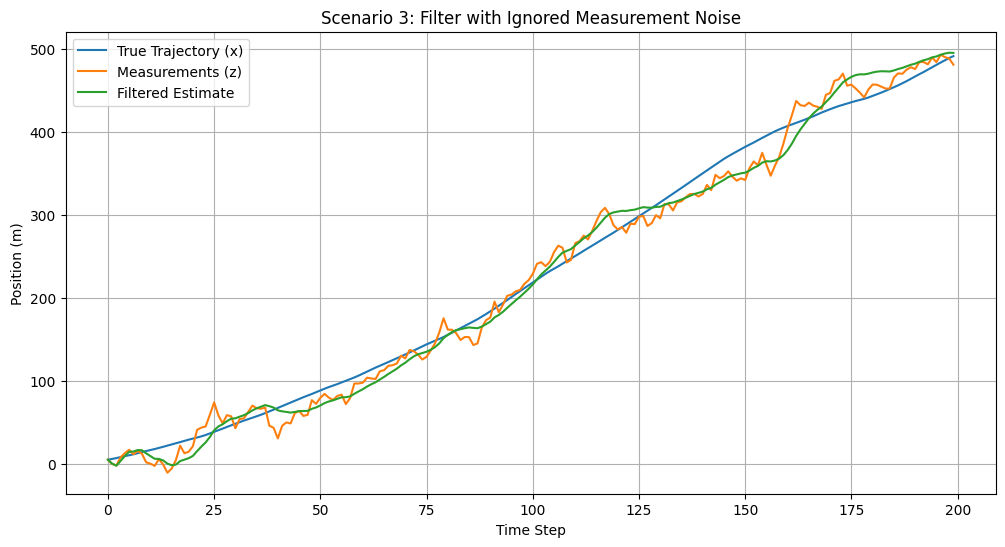

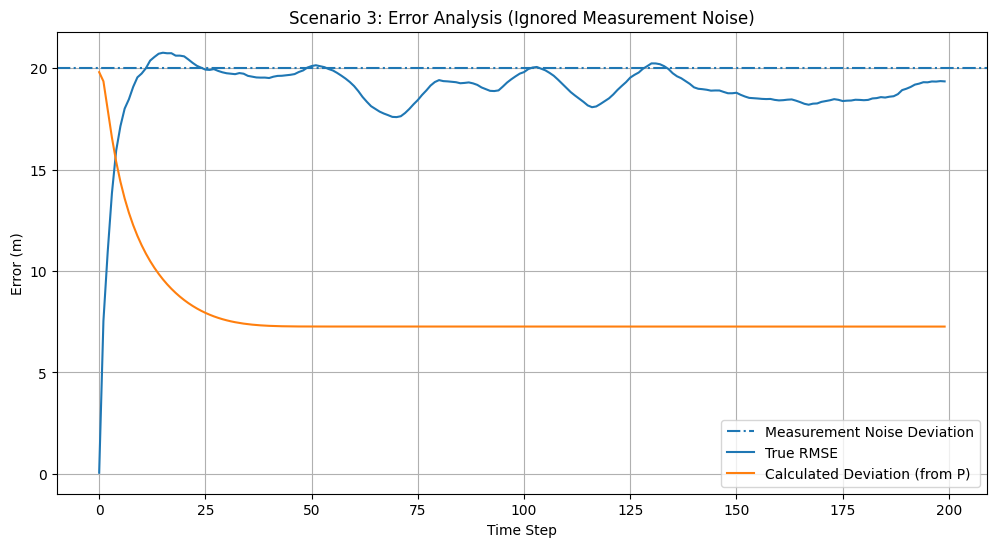

In [56]:
lambda_a_3, lambda_eta_3 = 1000, 0.1
x_true_3, _, z_3 = generate_trajectory_and_measurements(lambda_a_3, lambda_eta_3, N, T, x0, v0)
X_filtered_3, _, _, _, _, _ = run_kalman_filter(z_3, N, sigma_a_sq, X0_0_part1, P0_0_part1)

plt.figure(figsize=(12, 6))
plt.plot(x_true_3, label='True Trajectory (x)')
plt.plot(z_3, markersize=3, label='Measurements (z)')
plt.plot(X_filtered_3[:, 0, 0], label='Filtered Estimate')
plt.title('Scenario 3: Filter with Ignored Measurement Noise')
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

rmse_3, avg_calc_std_3 = run_kalman_filter_and_calculate_errors(lambda_a_3, lambda_eta_3)

plt.figure(figsize=(12, 6))
plt.axhline(y=sigma_eta_val, linestyle='-.', label='Measurement Noise Deviation')
plt.plot(rmse_3, label='True RMSE')
plt.plot(avg_calc_std_3, label='Calculated Deviation (from P)')
plt.title('Scenario 3: Error Analysis (Ignored Measurement Noise)')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

The true RMSE is much larger than the calculated standard deviation, making the filter bad. However, comparing the RMSE in Scenario 2 and 3, ignoring correlated measurements noise resulted in a larger estimation error for these specific noise statistics.

### Scenario 4: Ignoring Both Correlated State and Measurement Noise

**Non-optimal case:** Both the true acceleration and measurement noise are correlated (`λ=0.1`), but the filter assumes they are uncorrelated.

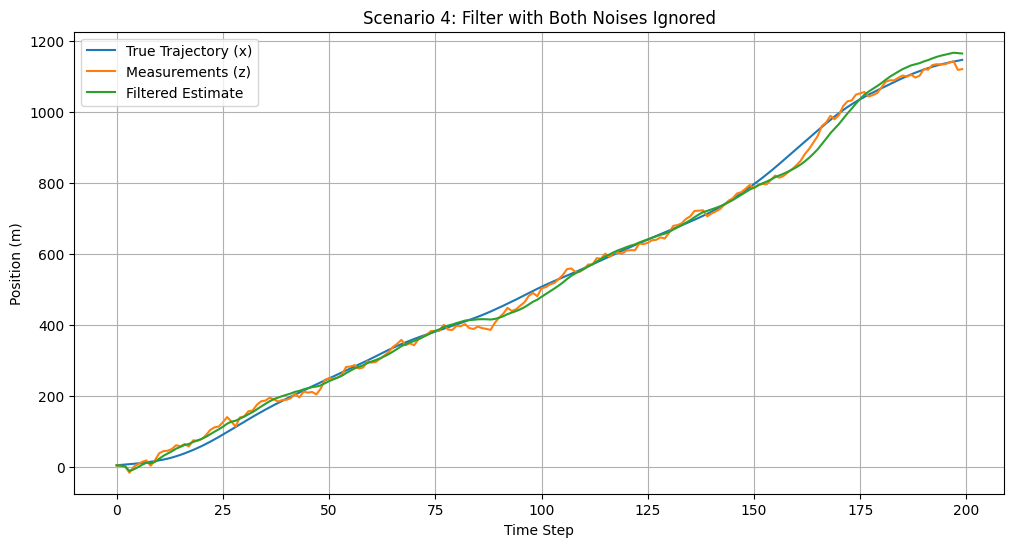

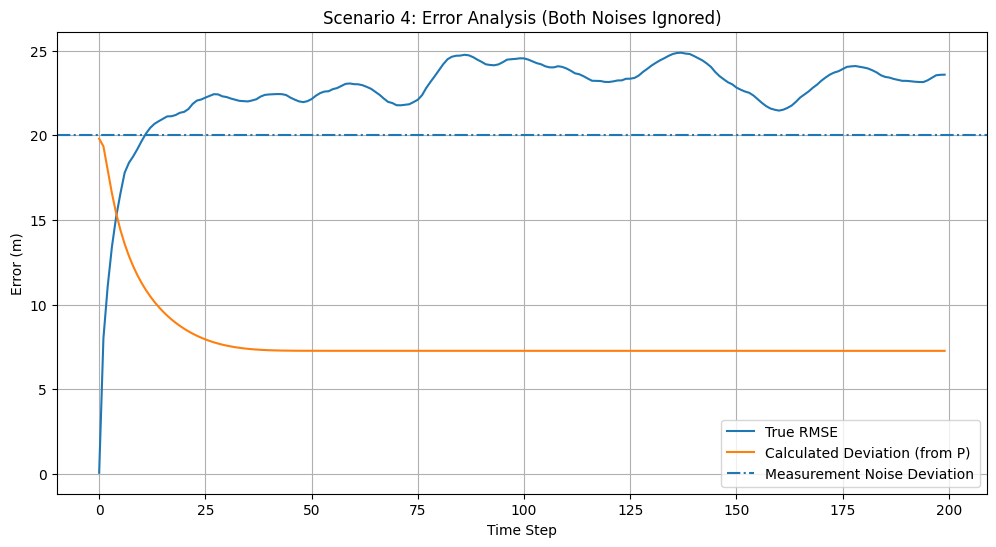

In [57]:
lambda_a_4, lambda_eta_4 = 0.1, 0.1
x_true_4, _, z_4 = generate_trajectory_and_measurements(lambda_a_4, lambda_eta_4, N, T, x0, v0)
X_filtered_4, _, _, _, _, _ = run_kalman_filter(z_4, N, sigma_a_sq, X0_0_part1, P0_0_part1)

plt.figure(figsize=(12, 6))
plt.plot(x_true_4, label='True Trajectory (x)')
plt.plot(z_4, markersize=3, label='Measurements (z)')
plt.plot(X_filtered_4[:, 0, 0], label='Filtered Estimate')
plt.title('Scenario 4: Filter with Both Noises Ignored')
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

rmse_4, avg_calc_std_4 = run_kalman_filter_and_calculate_errors(lambda_a_4, lambda_eta_4)

plt.figure(figsize=(12, 6))
plt.plot(rmse_4, label='True RMSE')
plt.plot(avg_calc_std_4, label='Calculated Deviation (from P)')
plt.axhline(y=sigma_eta_val, linestyle='-.', label='Measurement Noise Deviation')
plt.title('Scenario 4: Error Analysis (Both Noises Ignored)')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

When both correlations are ignored, the filter's performance is degraded. The divergence between the true error and the filter's self-reported error is increased, making the filter's output and its uncertainty estimates unreliable.

# Part II: Optimal Kalman Filtering with Correlated State Noise

Augmentation of the state vector to include acceleration, making its dynamics explicit in the model.

### Augmented State-Space Model

The new state vector is $X = [x, v, a]^T$. The state-space model becomes:
- $X_i = \Phi_{aug} X_{i-1} + G_{aug} \zeta_{i}$  
- $z_i = H_{aug} X_i + \eta_i$

Where $\zeta_i$ is the white noise driving the acceleration process, and $\eta_i$ is uncorrelated measurement noise.

In [58]:
def run_kalman_filter_aug(z, N, lambda_a):
    Phi_aug = np.array([[1, T, T**2/2],
                        [0, 1, T],
                        [0, 0, np.exp(-lambda_a * T)]])
    
    G_aug = np.array([[0], [0], [1]])
    
    H_aug = np.array([[1, 0, 0]])
    
    sigma_zeta_sq = sigma_a_sq * (1 - np.exp(-2 * lambda_a * T))
    Q_aug = G_aug @ G_aug.T * sigma_zeta_sq
    R_aug = np.array([[sigma_eta_sq]])

    X0_0 = np.array([[2.0], [0.0], [0.0]])
    P0_0 = np.diag([10000, 10000, 10000])

    X_filt_prev = X0_0
    P_filt_prev = P0_0
    
    X_filtered = np.zeros((N, 3, 1))
    P_filtered = np.zeros((N, 3, 3))
    X_predicted = np.zeros((N, 3, 1))
    P_predicted = np.zeros((N, 3, 3))

    for i in range(N):
        # Prediction
        X_pred = Phi_aug @ X_filt_prev
        P_pred = Phi_aug @ P_filt_prev @ Phi_aug.T + Q_aug
        
        # Filtration
        residual = z[i] - H_aug @ X_pred
        S = H_aug @ P_pred @ H_aug.T + R_aug
        K = P_pred @ H_aug.T @ np.linalg.inv(S)
        X_filt = X_pred + K @ residual
        P_filt = (np.eye(3) - K @ H_aug) @ P_pred
        
        # Save data
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_filtered, P_filtered, X_predicted, P_predicted

### Filter Performance Evaluation

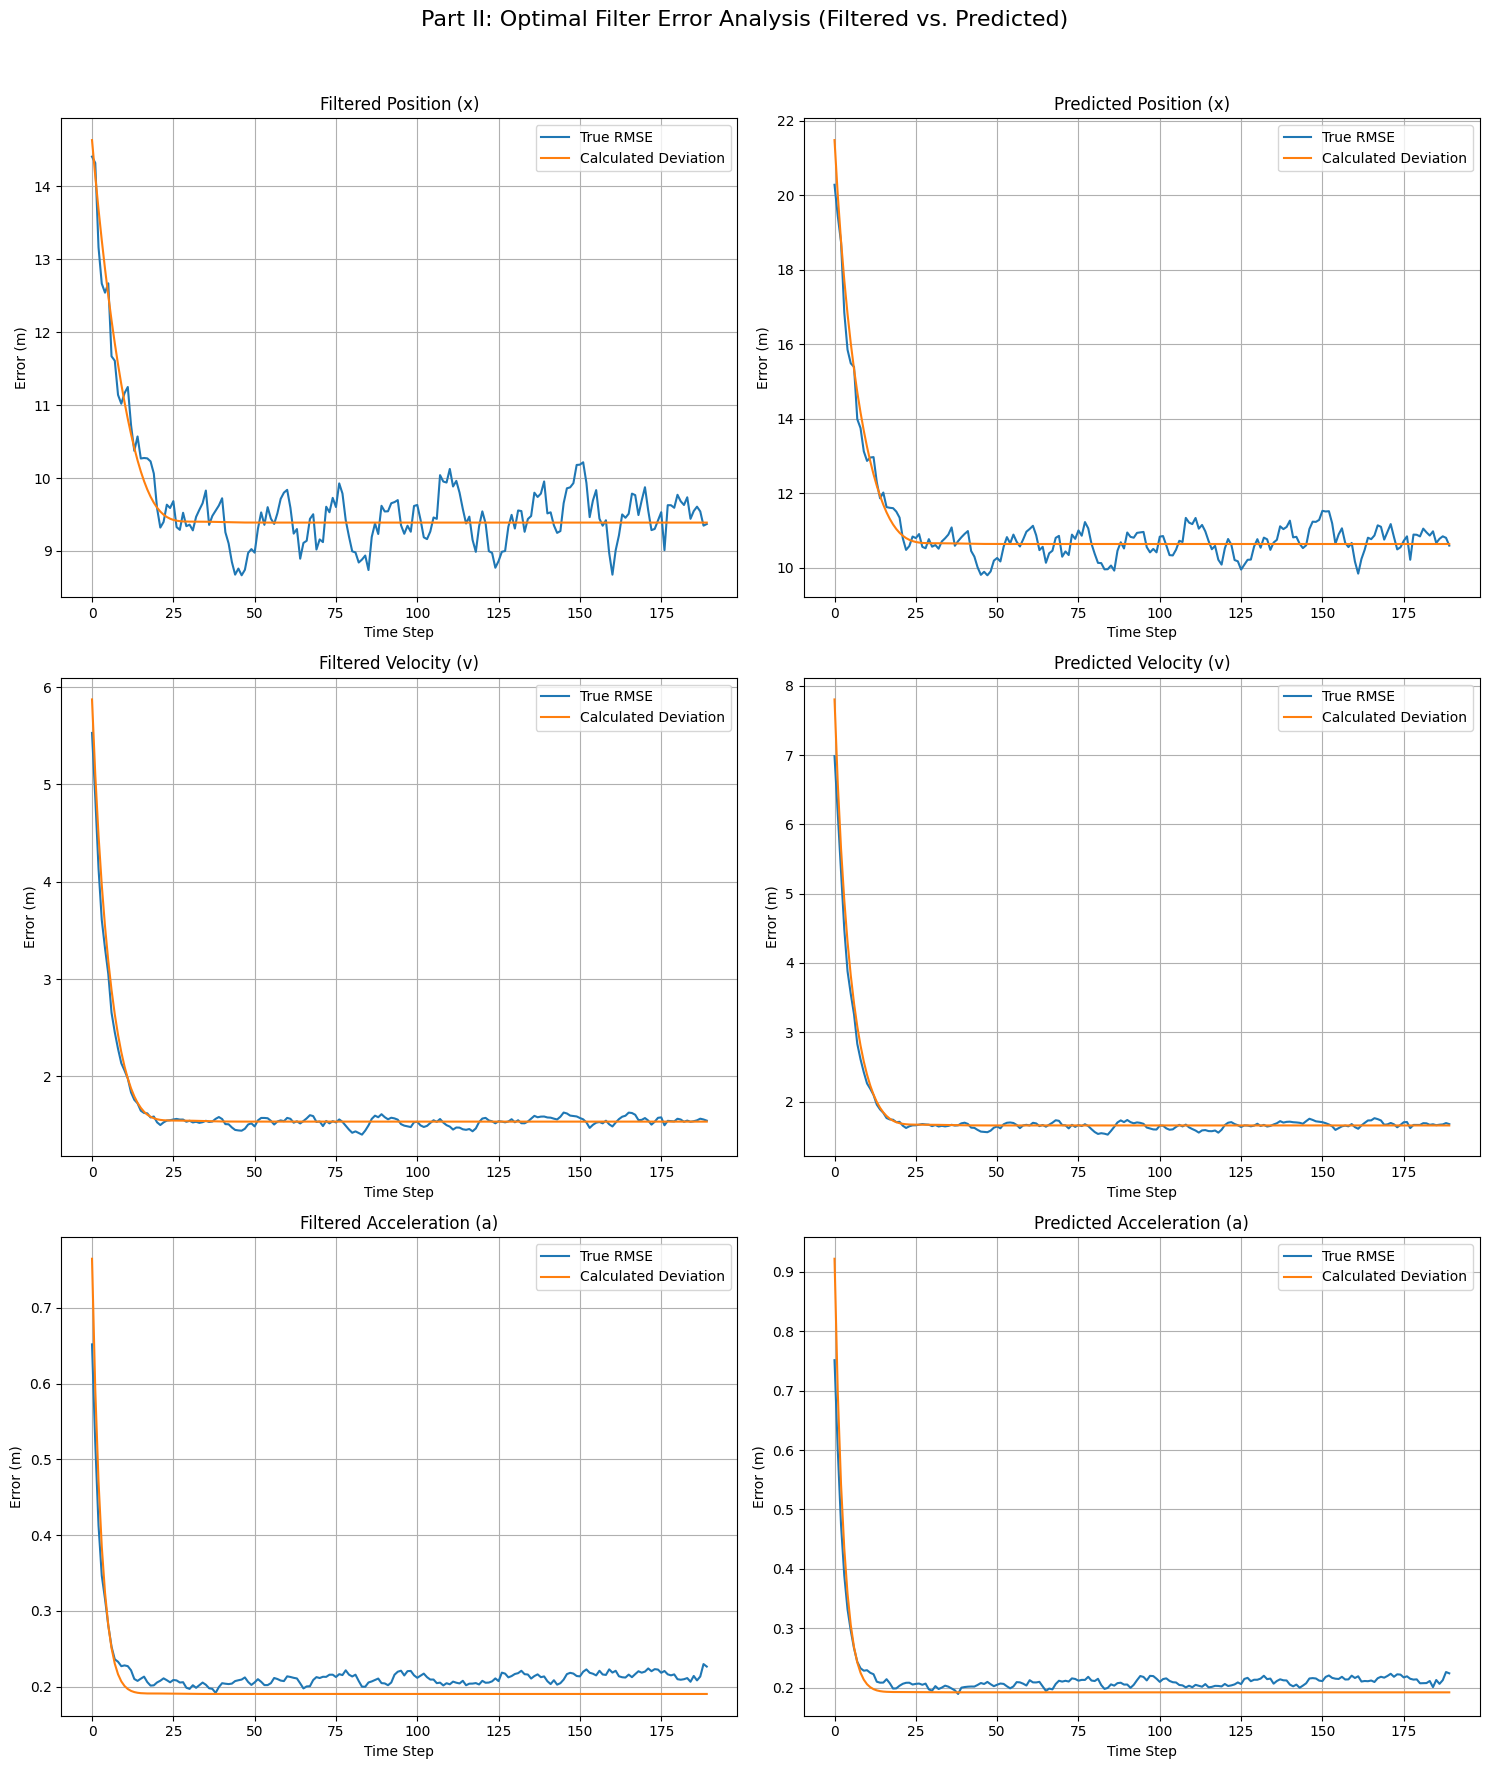

In [59]:
M = 500
lambda_a_part2, lambda_eta_part2 = 0.1, 1000

sq_err_filt_x, sq_err_filt_v, sq_err_filt_a = [np.zeros((M, N)) for _ in range(3)]
sq_err_pred_x, sq_err_pred_v, sq_err_pred_a = [np.zeros((M, N)) for _ in range(3)]
p_filt_diags = np.zeros((M, N, 3))
p_pred_diags = np.zeros((M, N, 3))

for m in range(M):
    x_true, v_true, z = generate_trajectory_and_measurements(lambda_a_part2, lambda_eta_part2, N, T, x0, v0)
    a_true = generate_correlated_noise(lambda_a_part2, sigma_a_sq, T, N)
    
    X_filt, P_filt, X_pred, P_pred = run_kalman_filter_aug(z, N, lambda_a_part2)
    X_true = np.vstack([x_true, v_true, a_true]).T
    
    # Filtered errors
    err_filt = X_true - X_filt[:, :, 0]
    sq_err_filt_x[m,:], sq_err_filt_v[m,:], sq_err_filt_a[m,:] = (err_filt**2).T
    p_filt_diags[m,:,:] = np.diagonal(P_filt, axis1=1, axis2=2)
    
    # Predicted errors
    err_pred = X_true - X_pred[:, :, 0]
    sq_err_pred_x[m,:], sq_err_pred_v[m,:], sq_err_pred_a[m,:] = (err_pred**2).T
    p_pred_diags[m,:,:] = np.diagonal(P_pred, axis1=1, axis2=2)

rmse_filt_x = np.sqrt(np.mean(sq_err_filt_x, axis=0))
rmse_filt_v = np.sqrt(np.mean(sq_err_filt_v, axis=0))
rmse_filt_a = np.sqrt(np.mean(sq_err_filt_a, axis=0))
avg_std_filt = np.sqrt(np.mean(p_filt_diags, axis=0))

rmse_pred_x = np.sqrt(np.mean(sq_err_pred_x, axis=0))
rmse_pred_v = np.sqrt(np.mean(sq_err_pred_v, axis=0))
rmse_pred_a = np.sqrt(np.mean(sq_err_pred_a, axis=0))
avg_std_pred = np.sqrt(np.mean(p_pred_diags, axis=0))

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Part II: Optimal Filter Error Analysis (Filtered vs. Predicted)', fontsize=16)

plot_titles = ['Position (x)', 'Velocity (v)', 'Acceleration (a)']
rmses_filt = [rmse_filt_x, rmse_filt_v, rmse_filt_a]
rmses_pred = [rmse_pred_x, rmse_pred_v, rmse_pred_a]

for i in range(3):
    # Filtered Estimates
    axes[i, 0].plot(rmses_filt[i][10:], label='True RMSE')
    axes[i, 0].plot(avg_std_filt[10:, i], label='Calculated Deviation')
    axes[i, 0].set_title(f'Filtered {plot_titles[i]}')
    axes[i, 0].set_xlabel('Time Step')
    axes[i, 0].set_ylabel('Error (m)')
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    
    # Predicted Estimates
    axes[i, 1].plot(rmses_pred[i][10:], label='True RMSE')
    axes[i, 1].plot(avg_std_pred[10:, i], label='Calculated Deviation')
    axes[i, 1].set_title(f'Predicted {plot_titles[i]}')
    axes[i, 1].set_xlabel('Time Step')
    axes[i, 1].set_ylabel('Error (m)')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

By including the correlated process (acceleration) in the state, we could model its dynamics explicitly. The resulting 3-state filter was consistent and performed optimally, accurately tracking not only position and velocity but also the underlying acceleration.

# Learning Log

Behavior and limitations of the Kalman filter, particularly in the context of tracking situations where noise sources are often correlated.

### Key Takeaways:

1. The performance of a Kalman filter is tied to the accuracy of its underlying model. When the filter's assumptions (uncorrelated noise) matched reality, it performed optimally and provided a reliable estimate of its own uncertainty. The calculated error was a trustworthy metric for the true error.

2. Scenarios 2, 3, and 4 demonstrated the consequences of using a mismatched model. When the true process involved correlated noise, the standard Kalman filter became wrong. The true estimation error (RMSE) was significantly larger than the error predicted by the filter's covariance matrix. This leads to an overconfident filter which might report a high degree of certainty for a very wrong estimate.

3. In our specific setup, ignoring the correlation in the measurement noise led to a larger degradation in performance than ignoring the correlation in the state noise. But both of them are extremely important.

4. The state vector augmenting can improve noise handling. By including the correlated process (acceleration) in the state, we could model its dynamics explicitly. The resulting 3-state filter was consistent and performed optimally, accurately tracking not only position and velocity but also the underlying acceleration.